In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from check_tests import check_test
from scipy.ndimage.filters import gaussian_filter
from skimage.metrics import peak_signal_noise_ratio
# !Этих импортов достаточно для решения данного задания, нельзя использовать другие библиотеки!

# PCA - метод главных компонент (3 балла за реализацию всего метода)
Пожалуй, стоит начать с краткого описания сути метода. Его идея заключается в преходе из пространства размерности $n$ в $m$-мерное пространство, где $m < n$. Например, рассмотрим черно-белую картинку размера $8\times8$ - его размерность, как вы уже могли догадаться, 64. Наша задача состоит в переходе в пространство меньшей размерности и возвращении обратно. Конечно, во время сжатия будет происходить утрата информации, поэтому в итоге мы получим алгоритм *сжатия с потерями.*

Изображение из описания выше задается набором 64 значений пикселей, который мы назовем вектором $x=[x_1, x2_,...,x_{64}]$. Тогда, картинку мы можем рассматривать в терминах пиксельного базиса. То есть $img(x)= x_1 \times(pixel_1) + x_2 \times(pixel_2) + ... + x_{64} \times(pixel_{64})$. Один из возможных способов понижения размерности - обнуление большей части базисных векторов. Очевидно, что из этого особо ничего хорошего не выйдет, мы потеряем слишком много информации и восстановить изображение корректно не получится.

Однако попиксельное представление - это не единственный вариант базиса. Возможно и использование других базисных функций, когда каждый пексель вносит в каждую из них некий заранее определенный вклад: $img(x)= average + x_1 \times(basis_1) + x_2 \times(basis_2) + ...$. Метод PCA можно рассматривать как процесс выбора оптимальных базисных функций, таких, чтобы комбинации лишь нескольких из них было достаточно для удовлетворительного воссоздания основной части элементов картинки. Главные компоненты, служащие низкоразмерным представлением данных, будут в этом случае просто коэффициентами, умножаемыми на каждый из элементов ряда.

**Подробнее про PCA можно прочитать [здесь](https://ru.wikipedia.org/wiki/Метод_главных_компонент) или [здесь](https://habr.com/ru/post/304214/).**

## Сжатие и восстановление изображения

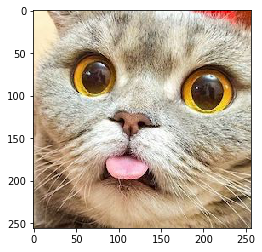

In [2]:
# Считываем и выводим изображение
img = imread('cat.jpg')
if len(img.shape) == 3:
    img = img[..., :3]
plt.imshow(img)

In [3]:
def pca_compression(matrix, p):
    """ Сжатие изображения с помощью PCA
    Вход: двумерная матрица (одна цветовая компонента картинки), количество компонент
    Выход: собственные векторы и проекция матрицы на новое пр-во
    """
    
    # Your code here
    
    # Отцентруем каждую строчку матрицы
    ...
    # Найдем матрицу ковариации
    ...
    # Ищем собственные значения и собственные векторы матрицы ковариации, используйте linalg.eigh из numpy
    ...
    # Посчитаем количество найденных собственных векторов
    ...
    # Сортируем собственные значения в порядке убывания
    ...
    # Сортируем собственные векторы согласно отсортированным собственным значениям
    # !Это все для того, чтобы мы производили проекцию в направлении максимальной дисперсии!
    ...
    # Оставляем только p собственных векторов
    ...
    # Проекция данных на новое пространство
    ...
    
    matrix = matrix - matrix.mean(axis=1).T
    cov = np.cov(matrix)
    vals, vecs = np.linalg.eigh(cov)
    vecs = np.matrix.transpose(vecs)
    args = vals.argsort()
    vecs = vecs[args[::-1]]
    p_vecs = vecs[:p:]
    return p_vecs.T, np.matmul(p_vecs, matrix)

In [4]:
def pca_decompression(img, compressed):
    """ Разжатие изображения
    Вход: исходное изображение; список кортежей из собственных векторов и проекций для каждой цветовой компоненты
    Выход: разжатое изображение
    """
    
    result_img = []
    for i, comp in enumerate(compressed):
        # Матрично умножаем собственные векторы на проекции и прибавляем среднее значение по строкам исходной матрицы
        # !Это следует из описанного в самом начале примера!
        vecs, proj = comp
        result_img.append(np.matmul(vecs, proj) + np.matrix.transpose(np.mean(img[:, :, i], axis=1)))
    return np.dstack((result_img[0], result_img[1], result_img[2]))

### Как будет выглядеть картинка при разном количестве компонент?

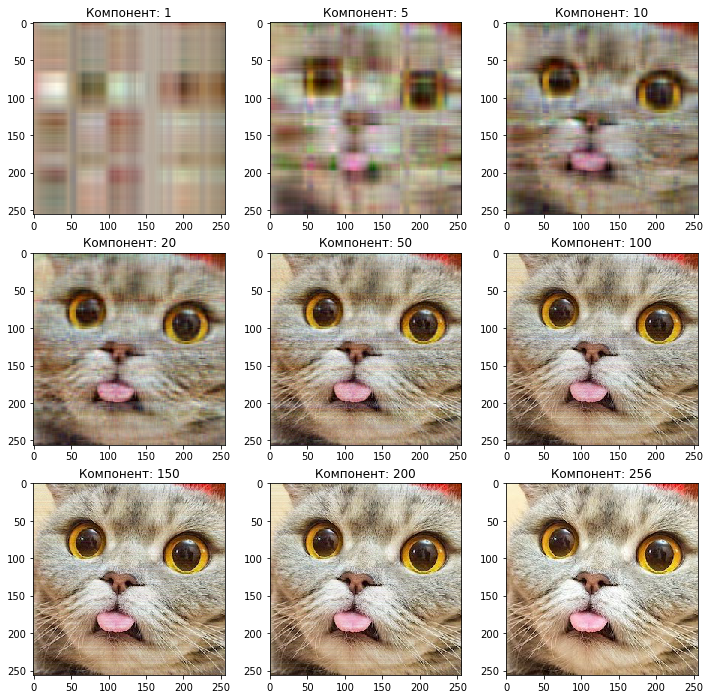

In [5]:
fig, axes = plt.subplots(3, 3)
fig.set_figwidth(12)
fig.set_figheight(12)

for i, p in enumerate([1, 5, 10, 20, 50, 100, 150, 200, 256]):
    compressed = []
    for j in range(0, 3):
        compressed.append(pca_compression(img[:, :, j], p))
    decompressed = pca_decompression(img, compressed).astype('float')
    show = np.clip(decompressed / np.max(decompressed), 0.0, 1.0)
    axes[i // 3, i % 3].imshow(show)
    axes[i // 3, i % 3].set_title('Компонент: {}'.format(p))

plt.show()

# JPEG (6 баллов за реализацию всего метода)

## Процедура кодирования
Первая часть данного подзадания заключается в реализации процедуры сжатия изображения. В конце мы должны получить изображение, имеющее меньший объем.

### Переход из одного пространства в другое и обратно (0.5 баллов, включая эксперимент с размытием)

Первым этапом в JPEG-сжатии является переход из пространства RGB в пространство YCbCr

*Из RGB в YCbCR:*

$$\begin{bmatrix}Y \\C_b\\ C_r \end{bmatrix} = \begin{bmatrix}0 \\128 \\ 128 \end{bmatrix} + \begin{bmatrix}0.299&0.587&0.114\\-0.1687&-0.3313&0.5\\0.5 & -0.4187&-0.0813 \end{bmatrix}\cdot\begin{bmatrix}R \\G \\ B \end{bmatrix}$$

*Из YCbCR в RGB:*
$$\begin{bmatrix}R \\G\\ B \end{bmatrix} = \begin{bmatrix}1& 0& 1.402\\1& -0.34414& -0.71414\\1& 1.77& 0 \end{bmatrix} \cdot\begin{bmatrix}Y \\C_b-128\\C_r-128 \end{bmatrix}$$

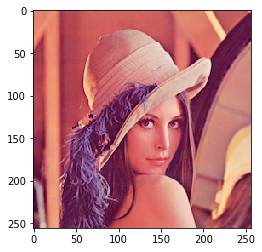

In [6]:
# Считываем и выводим изображение
rgb_img = imread('Lenna.png')
if len(rgb_img.shape) == 3:
    rgb_img = rgb_img[..., :3]
plt.imshow(rgb_img)

In [7]:
def rgb2ycbcr(img):
    """ Переход из пр-ва RGB в пр-во YCbCr
    Вход: RGB изображение
    Выход: YCbCr изображение
    """
    ans = img.copy()
    matrix = [[0.299, 0.587, 0.114], [-0.1687, -0.3313, 0.5], [0.5, -0.4187, -0.0813]]
    for row in ans:
        for i in range(len(row)):
            row[i] = [0, 128, 128] + np.matmul(matrix, row[i].T)
    return ans

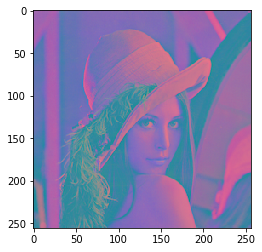

In [8]:
# Переводим из RGB в YCbCr и выводим результат
ycbcr_img = rgb2ycbcr(rgb_img)
plt.imshow(ycbcr_img)

In [9]:
def ycbcr2rgb(img):
    """ Переход из пр-ва YCbCr в пр-во RGB
    Вход: YCbCr изображение
    Выход: RGB изображение
    """
    
    ans = img.copy()
    matrix = [[1, 0, 1.402], [1, -0.34414, -0.71414], [1, 1.77, 0]]
    for row in ans:
        for i in range(len(row)):
            row[i] = np.matmul(matrix, (row[i] - [0, 128, 128]).T)
    return ans

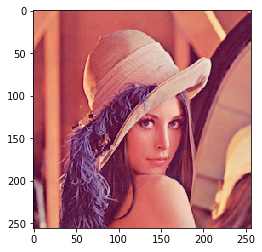

In [10]:
# Возвращаемся обратно к RGB и выводим картинку
rgb_img = ycbcr2rgb(ycbcr_img)
plt.imshow(rgb_img)

#### Размоем цвет и яркость

Факт, являющийся основополагающим в JPEG-сжатии, - это то, что человеческое зрение более чувствительно к изменению яркости, нежели к изменению цвета. Давайте проверим эту гипотезу (скорее, аксиому)!

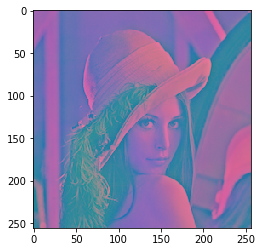

In [11]:
"""Этап 1
Компоненту яркости Y оставим такой, какая она есть.
Цветовые компоненты Cb и Cr размоем с помощью фильтра Гаусса.
Объединим все компоненты в одну картинку и переведем ее обратно в RGB. 
Выедем результат и посмотрим насколько он отличается от исходной картинки.
"""

sigma = 5
y = ycbcr_img[:, :, 0]
cb = ycbcr_img[:, :, 1]
cr = ycbcr_img[:, :, 2]
cb = gaussian_filter(cb, sigma)
cr = gaussian_filter(cr, sigma)

plt.imshow(np.dstack((y, cb, cr)))

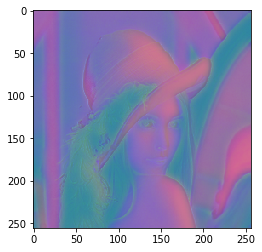

In [12]:
"""Этап 2
Компоненту яркости Y размоем с помощью фильтра Гаусса.
Цветовые компоненты Cb и Cr оставим такими, какие они есть.
Объединим все компоненты в одну картинку и переведем ее обратно в RGB. 
Выедем результат и посмотрим насколько он отличается от исходной картинки.
"""

sigma = 5
y = ycbcr_img[:, :, 0]
cb = ycbcr_img[:, :, 1]
cr = ycbcr_img[:, :, 2]
y = gaussian_filter(y, sigma)

plt.imshow(np.dstack((y, cb, cr)))

Если вы в обоих случаях использовали одни и те же параметры в фильтре Гаусса, и в первом случае получили картинку, слабо отличающуюся от исходной, а во втором - напротив, то поздравляем - вы экспериментально доказали анатомический факт!

### Уменьшение цветовых компонент (0.25 баллов)
Следующий шаг в алгоритме JPEG - уменьшение разрешения цветовых компонент.

**Вопрос:** во сколько раз нужно уменьшить цветовые компоненты?

**Ответ:** подобный параметр подбирается везде по-разному. Мы будем уменьшать цветовые компоненты в 2 раза.

**Вопрос:** как именно уменьшать?

**Ответ:** в этом разделе рассмотрим следующий прием:

1. Размываем цветовые компоненты с помощью фильтра Гаусса
2. Убираем каждую вторую строчку и столбец

In [13]:
def downsampling(component):
    """Уменьшаем цветовые компоненты в 2 раза
    Вход: цветовая компонента размера [A, B, 1]
    Выход: цветовая компонента размера [A // 2, B // 2, 1]
    """
    
    sigma = 1
    component = gaussian_filter(component, sigma).astype('float')
    return component[::2, ::2]

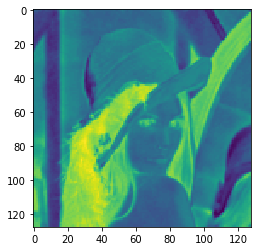

In [14]:
# Уменьшаем Cb компоненту в 2 раза и выводим результат
y = ycbcr_img[:, :, 0]
cb = ycbcr_img[:, :, 1]
cr = ycbcr_img[:, :, 2]
cb_component = downsampling(cb)
plt.imshow(cb_component)

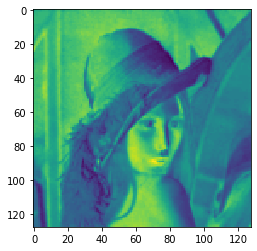

In [15]:
# Уменьшаем Cr компоненту в 2 раза и выводим результат
cr_component = downsampling(cr)
plt.imshow(cr_component)

### Деление компонент на блоки
Далее изображение делится на блоки равного размера. Чаще всего картинку делят на квадраты размера $8\times8$. Это связано с тем, что блок должен содержать +/- однородную информацию, например, только часть неба или какой-нибудь текстуры.

Для ускорения программы мы будем делить компоненты на блоки и производить над ними операции, которые будут описаны ниже, одновременно. Поэтому сам процесс деления будет необходимо реализовать чуть позже в общем цикле.


### Дискретное косинусное преобразование (0.5 баллов)
Дискретное косинусное преобразование производится по следующей формуле:

$$G_{u,v} = \frac{1}{4}\alpha(u)\alpha(v)\sum_{x=0}^{7}\sum_{y=0}^{7}g_{x,y}\cos\left[\frac{(2x+1)u\pi}{16}\right]\cos\left[\frac{(2y+1)v\pi}{16}\right],$$

где $g$ - матрица до ДКП, $G$ - после ДКП. $\alpha(u) = \frac{1}{\sqrt{2}}$, если $u=0$, иначе $\alpha(u) = 1$. 

In [16]:
def dct(block):
    """Дискретное косинусное преобразование
    Вход: блок размера 8x8
    Выход: блок размера 8x8 после ДКП
    """

    ans = np.zeros(np.shape(block)).astype('float')
    for u in range(8):
        for v in range(8):
            sums = 0
            for x in range(8):
                for y in  range(8):
                    sums += block[x][y].astype('float') * np.cos((2 * x + 1) * u * np.pi / 16.0) * np.cos((2 * y + 1) * v * np.pi / 16.0)
            if u == 0:
                sums *= 1.0 / np.sqrt(2)
            if v == 0:
                sums *= 1.0 / np.sqrt(2)    
            ans[u][v] = sums / 4.0      
    return ans.astype('float')

#### Тесты


In [17]:
# !ЗДЕСЬ НИЧЕГО НЕ МЕНЯТЬ!

block_1 = np.array([
    [-76, -73, -67, -62, -58, -67, -64, -55],
    [-65, -69, -73, -38, -19, -43, -59, -56],
    [-66, -69, -60, -15, 16, -24, -62, -55],
    [-65, -70, -57, -6, 26, -22, -58, -59],
    [-61, -67, -60, -24, -2, -40, -60, -58],
    [-49, -63, -68, -58, -51, -60, -70, -53],
    [-43, -57, -64, -69, -73, -67, -63, -45],
    [-41, -49, -59, -60, -63, -52, -50, -34]
])

block_2 = np.array([
    [11, 16, 21, 25, 27, 27, 27, 27],
    [16, 23, 25, 28, 31, 28, 28, 28],
    [22, 27, 32, 35, 30, 28, 28, 28],
    [31, 33, 34, 32, 32, 31, 31, 31],
    [31, 32, 33, 34, 34, 27, 27, 27],
    [33, 33, 33, 33, 32, 29, 29, 29],
    [34, 34, 33, 35, 34, 29, 29, 29],
    [34, 34, 34, 33, 35, 30, 30, 30]
])

check_test('dct', [dct(block_1), dct(block_2)])

OK!


### Квантование (0.5 баллов, включая самостоятельную генерацию матрицы квантования)
Человеческий глаз очень хорошо улавливает низкие частоты, а вот высокие - нет. Поэтому появилась следующая мысль: почему бы не удалить высокие частоты? Действительно, сокращая их, мы не очень сильно портим картинку, но при этом ее объем может быть сокращен в несколько раз. Именно для этого и применяют квантование.

**Идея квантования:** каждый элемент каждой комопоненты мы делим на некое число, а потом округляем результат. После столь нехитрой операции мы получим очень много нулей, которые будут характеризовать высокие частоты. Ноль не несет в себе особой информации, поэтому мы его можем смело удалить (об это подробнее будет описано ниже). Таким образом, объем картинки сократился в разы. Именно на этом этапе происходит потеря иформации. Наверное, вы уже догадались почему алгоритм сжатия JPEG - это *сжатие с потерями.*

**Как выбрать число, на которое будем делить?**

Существуют различные так называемые матрицы квантования. В коде задания приведены 2 варианта "основных" матриц. Для тех, кто хочет провести больше экспериментов с алгоритмом JPEG, чуть ниже будет предложено самим сформировать матрицы квантования.

In [18]:
# !ЗДЕСЬ НИЧЕГО НЕ МЕНЯТЬ!

# Матрица квантования яркости
y_quantization_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Матрица квантования цвета
color_quantization_matrix = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

In [19]:
def quantization(block, quantization_matrix):
    """Квантование
    Вход: блок размера 8x8 после применения ДКП; матрица квантования
    Выход: блок размера 8x8 после квантования. Округление осуществляем с помощью np.round
    """
    
    
    return np.round(np.divide(block.astype('float'), quantization_matrix)).astype('int')

#### Тесты

In [20]:
# !ЗДЕСЬ НИЧЕГО НЕ МЕНЯТЬ!

check_test('quantization', [quantization(dct(block_1), y_quantization_matrix), 
                            quantization(dct(block_2), color_quantization_matrix)])

OK!


#### Самостоятельная генерация матрицы квантования
Введем так называемый Quality Factor $Q \in \left[1,100\right]$, с помощью него мы сможем "управлять" процессом сжатия. $Q$ задается пользователем, а на его основании вычисляется Scale Factor $S$ следующим образом: 

$$S = \begin{cases}\frac{5000}{Q} & 1 \leq Q < 50 \\200 - 2Q & 50\leq Q \leq 99\\1 & Q = 100\end{cases}$$

После этого берутся "основные" матрицы квантования, которые были приведены чуть выше, и пересчитываются их коэффициенты следующим образом:

$$Q_{i,j} = \lfloor \frac{50+S \times D_{i,j}}{100}\rfloor,$$

где $D_{i, j}$ - значение $[i, j]$ элемента в "основной" матрице. Обратите внимание на округление вниз в формуле. Как вы уже могли догадаться, при $Q = 50$ мы будем иметь матрицы, равные "основным".

**Подробнее можно прочитать [здесь](https://arxiv.org/pdf/1802.00992.pdf) (см. п.2.1).**


In [21]:
def own_quantization_matrix(default_quantization_matrix, q):
    """Генерация матрицы квантования по Quality Factor
    Вход: "стандартная" матрица квантования; Quality Factor
    Выход: новая матрица квантования
    Hint: если после проделанных операций какие-то элементы обнулились, то замените их единицами
    """

    assert 1 <= q <= 100
    ans = np.zeros(np.shape(default_quantization_matrix)).astype('float')
    if q < 50:
        s = 5000.0 / q
    elif q < 99:
        s = 200.0 - 2 * q
    else:
        s = 1.0
    for i in range(len(default_quantization_matrix)):
        for j in range(len(default_quantization_matrix[0])):
            ans[i][j] = (50 + s * default_quantization_matrix[i][j]) // 100
            if ans[i][j] == 0:
                ans[i][j] = 1
    return ans

#### Тесты

In [22]:
# !ЗДЕСЬ НИЧЕГО НЕ МЕНЯТЬ!

check_test('own_quantization', [own_quantization_matrix(y_quantization_matrix, 50), 
                               own_quantization_matrix(color_quantization_matrix, 50),
                               own_quantization_matrix(y_quantization_matrix, 75),
                               own_quantization_matrix(color_quantization_matrix, 98)])

OK!


### Зигзаг-сканирование и сжатие (1 балл)
Сначала необходимо обойти полученный массив (блок) специальным образом:

![zigzag](img/zigzag.png)

Далее начинается самое интресное - сжатие. После зигзаг-сканирования мы получили одномерный массив. Теперь нам нужно его каким-то образом сжать. Как было сказано выше, после квантования у нас должно получиться много нулей, от них нужно как-то избавиться. Для этого вместо последовательности из множества нулей мы вписываем 1 нуль и после него число, обозначающее их количество в последовательности.

**Пример:**

![example](img/example.jpeg)

In [23]:
def zigzag(block):
    """Зигзаг-сканирование
    Вход: блок размера 8x8
    Выход: список из элементов входного блока, получаемый после его обхода зигзаг-сканированием
    """
    ans = []
    for diagonal in range(15):
            for i in range(max(0, diagonal - 7), min(8, diagonal+1)):
                if diagonal % 2 == 0:
                    ans.append(block[diagonal - i][i])
                else:
                    ans.append(block[i][diagonal - i])
    return np.array(ans).astype('int')

#### Тесты

In [24]:
# !ЗДЕСЬ НИЧЕГО НЕ МЕНЯТЬ!

check_test('zigzag', [zigzag(quantization(dct(block_1), y_quantization_matrix)),
                      zigzag(quantization(dct(block_2), color_quantization_matrix))])

OK!


In [25]:
def compression(zigzag_list):
    """Сжатие последовательности после зигзаг-сканирования
    Вход: список после зигзаг-сканирования
    Выход: сжатый список в формате, который был приведен в качестве примера в самом начале данного пункта
    """
    ans = []
    i = 0
    while i < len(zigzag_list):
        if zigzag_list[i] != 0:
            ans.append(zigzag_list[i])
            i += 1
        else:
            counter = 0
            while i < len(zigzag_list) and zigzag_list[i] == 0:
                counter += 1
                i += 1
            ans.append(0)
            ans.append(counter)
    return np.array(ans).astype('int')

#### Тесты

In [26]:
# !ЗДЕСЬ НИЧЕГО НЕ МЕНЯТЬ!

check_test('compression', [compression([0]), compression([0, 0, 0, 0, 0]),
                          compression([17, 8, 54, 0, 0, 0, 97, 5, 16, 0, 45, 23, 0, 0, 0, 0, 0, 3, 67, 0, 0, 8]),
                          compression(zigzag(quantization(dct(block_1), y_quantization_matrix)))])

OK!


In [27]:
#y_quantization_matrix = own_quantization_matrix(y_quantization_matrix, 20)

### Финал (почти)
Теперь необходимо все написанные выше функции соединить воедино.

**Алгоритм:**

1. Переводим картинку в YCbCr
2. Уменьшаем цветовые компоненты
3. Делим все компоненты на блоки 8x8 и все элементы блоков переводим из $[0, 255]$ в $[-128, 127]$
4. Ко всем блокам последовательно применяем дискретное косинусное преобразование, квантование (если вы реализовали свои матрицы квантования, то можете использовать их), зигзаг-сканирование и сжатие
5. Сохраняем в списки полученные сжатые данные

In [28]:
def compress_ch(ch, quantization_matrix):
    ans = []
    h = ch.shape[0]
    w = ch.shape[1]
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = ch[i:i+8:, j:j+8:] - 128
            ans.append(compression(zigzag(quantization(dct(block), quantization_matrix))))
    return ans

def jpeg_compression(img, quantization_matrixes):
    """JPEG-сжатие
    Вход: цветная картинка, список из 2-ух матриц квантования
    Выход: список списков со сжатыми векторами: [[compressed_y1,...], [compressed_Cb1,...], [compressed_Cr1,...]]
    """

    # Your code here
    # Переходим из RGB в YCbCr
    ...
    # Уменьшаем цветовые компоненты
    ...
    # Делим все компоненты на блоки 8x8 и все элементы блоков переводим из [0, 255] в [-128, 127]
    ...
    # Применяем ДКП, квантование, зизгаз-сканирование и сжатие
    ...
    ycbcr_img = rgb2ycbcr(img)
    y = ycbcr_img[:, :, 0]
    cb = downsampling(ycbcr_img[:, :, 1])
    cr = downsampling(ycbcr_img[:, :, 2])
    return [compress_ch(y, quantization_matrixes[0]), compress_ch(cb, quantization_matrixes[1]), compress_ch(cr, quantization_matrixes[1])]

In [29]:
result = jpeg_compression(rgb_img, [y_quantization_matrix, color_quantization_matrix])

*Теперь, если все было сделано верно, то в result должны находиться сжатые блоки компонент изображения.*

## Процедура декодирования
Отлично, половина пути пройдена! В предыдущей части мы получили сжатые блоки компонент изображения. Теперь задача заключается в декодировании этих блоков и возвращении к исходному изображению. В итоге мы должны получить практически такое же изображение, которое было до процедуры сжатия.

### Обратное сжатие и зигзаг-сканирование (1 балл)
Здесь и далее для разжатия изображения необходимо выполнить в обратном порядке обратные операции к тем, которые были применены в разделе "Процедура кодирования". Начнем с обратного сжатия и зигзаг-сканирования. 

Суть первого заключается в том, что из короткого вектора, где последовательности из нулей были заменены на пары вида <0, длина нулевой последовательности>, необходимо обратно получить вектор "полной длины", т.е. указанные пары меняются на последовательности нулей указанной длины.

Вторая операция чуть сложнее - необходимо от полученного на предыдущем шаге вектора перейти к двумерной матрице, т.е. расставить его элементы в матрице в порядке их следования в зигзаг-сканировании.

In [30]:
def inverse_compression(compressed_list):
    """Разжатие последовательности
    Вход: сжатый список
    Выход: разжатый список
    """
    ans = []
    i = 0
    while i < len(compressed_list):
        if compressed_list[i] != 0:
            ans.append(compressed_list[i])
        else:
            i += 1
            for k in range(compressed_list[i]):
                ans.append(0)
        i += 1
    return np.array(ans).astype('int')

#### Тесты

In [31]:
# !ЗДЕСЬ НИЧЕГО НЕ МЕНЯТЬ!

check_test('inverse_compression', [inverse_compression(compression([0])), inverse_compression(compression([0, 0, 0, 0, 0])),
                                   inverse_compression(compression([17, 8, 54, 0, 0, 0, 97, 5, 16, 0, 45, 23, 0, 0, 0, 0, 0, 3, 67, 0, 0, 8])),
                                   inverse_compression(compression(zigzag(quantization(dct(block_1), y_quantization_matrix))))])

OK!


In [32]:
def inverse_zigzag(input):
    """Обратное зигзаг-сканирование
    Вход: список элементов
    Выход: блок размера 8x8 из элементов входного списка, расставленных в матрице в порядке их следования в зигзаг-сканировании
    """

    ans = np.zeros((8, 8))
    curr = 0
    for diagonal in range(15):
        for i in range(max(0, diagonal - 7), min(8, diagonal+1)):
            if diagonal % 2 == 0:
                ans[diagonal - i][i] = input[curr]
            else:
                ans[i][diagonal - i] = input[curr]
            curr += 1
    return np.array(ans).astype('int')

#### Тесты

In [33]:
# !ЗДЕСЬ НИЧЕГО НЕ МЕНЯТЬ!

check_test('inverse_zigzag', [inverse_zigzag(zigzag(quantization(dct(block_1), y_quantization_matrix))),
                              inverse_zigzag(zigzag(quantization(dct(block_2), color_quantization_matrix)))])

OK!


### Обратное квантование и дискретное косинусное преобразование (0.75 баллов)
Суть обратного квантования заключается в домножении поданной на вход матрицы на матрицу квантования (если в кодировании вы использовали свои матрицы квантования, то при конечном декодировании не забудьте использовать именно их).

Обратное дискретное косинусное преобразование производится по следующей формуле:

$$f_{x,y} = \frac{1}{4}\sum_{u=0}^{7}\sum_{v=0}^{7}\alpha(u)\alpha(v)F_{u,v}\cos\left[\frac{(2x+1)u\pi}{16}\right]\cos\left[\frac{(2y+1)v\pi}{16}\right],$$

где $F$ - матрица до обратного ДКП, $f$ - после обратного ДКП. $\alpha(u) = \frac{1}{\sqrt{2}}$, если $u=0$, иначе $\alpha(u) = 1$. Не забываем округлять результат обратного ДКП, т.к. пиксели имеют целые значения из диапазона $[0, 255]$.

In [34]:
def inverse_quantization(block, quantization_matrix):
    """Обратное квантование
    Вход: блок размера 8x8 после применения обратного зигзаг-сканирования; матрица квантования
    Выход: блок размера 8x8 после квантования. Округление не производится
    """
    
    return np.multiply(block, quantization_matrix).astype('float')

#### Тесты

In [35]:
# !ЗДЕСЬ НИЧЕГО НЕ МЕНЯТЬ!

check_test('inverse_quantization', [inverse_quantization(quantization(dct(block_1), y_quantization_matrix), y_quantization_matrix),
                              inverse_quantization(quantization(dct(block_2), color_quantization_matrix), color_quantization_matrix)])

OK!


In [36]:
def inverse_dct(block):
    """Обратное дискретное косинусное преобразование
    Вход: блок размера 8x8
    Выход: блок размера 8x8 после обратного ДКП. Округление осуществляем с помощью np.round
    """

    ans = np.zeros(np.shape(block)).astype('float')
    for x in range(8):
        for y in range(8):
            for u in range(8):
                for v in range(8):
                    sums = block[u][v].astype('float') * np.cos((2 * x + 1) * u * np.pi / 16.0) * np.cos((2 * y + 1) * v * np.pi / 16.0)
                    if u == 0:
                        sums *= 1.0 / np.sqrt(2)
                    if v == 0:
                        sums *= 1.0 / np.sqrt(2)
                    ans[x][y] += sums
            ans[x][y] = np.round(ans[x][y].astype('float') /  4.0)  
    return ans.astype('int')

#### Тесты

In [37]:
# !ЗДЕСЬ НИЧЕГО НЕ МЕНЯТЬ!

check_test('inverse_dct', [inverse_dct(inverse_quantization(quantization(dct(block_1), y_quantization_matrix), y_quantization_matrix)), 
                              inverse_dct(inverse_quantization(quantization(dct(block_2), color_quantization_matrix), color_quantization_matrix))])

OK!


### Увеличение цветовых компонент (0.5 баллов)
Как вы помните, в самом начале нашего пути мы уменьшили цветовые компоненты в 2 раза. Пришло время вернуть все как было. Для этого будем просто дублировать все пиксели: рассмотрим i-ю строчку, в которой был удален j-ый элемент, восстановим его значение с помощью значения элемента в позиции (i, j - 1); таким образом восстанавливаем i-ю строчку, далее, например, нами была удалена (i + 1)-я строчка, тогда в нее дублируем (i - 1)-ю строчку, и так далее.

In [38]:
def upsampling(component):
    """Увеличиваем цветовые компоненты в 2 раза
    Вход: цветовая компонента размера [A, B, 1]
    Выход: цветовая компонента размера [2 * A, 2 * B, 1]
    """
    
    tmp = []
    for row in component:
        tmp.append(row)
        tmp.append(row)
    tmp = np.matrix.transpose(np.array(tmp))
    ans = []
    for row in tmp:
        ans.append(row)
        ans.append(row)
    ans = np.matrix.transpose(np.array(ans)).astype('int')
    return ans

### Финал (теперь точно)
Все, что осталось - это все написанные выше функции соединить воедино.

**Алгоритм:**

1. Для всех векторов из result последовательно применяем следующие функции: обратное сжатие и зигзаг-сканирование, обратное квантование (если вы использовали свои матрицы квантования, то на этом этапе нужно применять именно их) и дискретное косинусное преобразование
2. После первого шага для каждой компоненты будем иметь набор блоков. Соединяем все эти блоки в 3 компоненты (не забываем значения каждого блока обратно переводить из $[-128, 127]$ в $[0, 255]$), т.е. в итоге должны получить полноразмернную компоненту яркости и две компоненты цвета, уменьшенные в 2 раза
3. Обе цветовые компоненты увеличиваем в 2 раза
4. Все компоненты объединяем в одно YCbCr изображение
5. Полученное изображение переводим обратно в RGB
6. Выводим результат
7. Удивляемся!

In [51]:
def ch_decompression(compressed_ch, quantization_matrix):
    n = np.sqrt(len(compressed_ch)).astype('int')
    ch = np.zeros((8 * n, 8 * n))
    for i in range(len(compressed_ch)):
        block = inverse_dct(inverse_quantization(inverse_zigzag(inverse_compression(compressed_ch[i])), quantization_matrix))
        x = i // n * 8
        y = i % n * 8
        ch[x:x+8:, y:y+8] = block
    return ch.astype('int') + 128

def jpeg_decompression(result, quantization_matrixes):
    """Разжатие изображения
    Вход: result список сжатых данных, список из 2-ух матриц квантования
    Выход: разжатое изображение
    """
    y = ch_decompression(result[0], quantization_matrixes[0])
    cb = upsampling(ch_decompression(result[1], quantization_matrixes[1]))
    cr = upsampling(ch_decompression(result[2], quantization_matrixes[1]))
    ycbcr_img = np.dstack((np.mod(y, 256), np.mod(cb, 256), np.mod(cr, 256)))
    rgb_img = ycbcr2rgb(ycbcr_img)
    return rgb_img.astype('int')

In [52]:
result_img = jpeg_decompression(result, [y_quantization_matrix, color_quantization_matrix])

#### Как итог выполненной работы: до +1 балла за полученную сжатую картинку

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


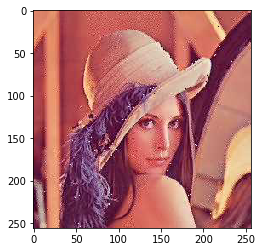

In [53]:
plt.imshow(result_img)

**Впечатлены результатом?**

Для тех, кому больше всего понравилось это задание, предлагается провести еще несколько дополнительных экспериментов:

1. Посчитайте объем сжатой картинки (естественно, нужно вычислять объем тех данных, которые были получены в конце раздела "Процедура кодирования"). Насколько изменился вес картинки?
2. Поэкспериментируйте со значениями Quality Factor. Как будет выглядеть изображение при $Q=1$, $Q=100$?
3. Как значение Quality Factor влияет на объем сжатой картинки?

# Общий Pipeline
Ниже для вашего удобства представлен Pipeline. Это сделано сугубо для удобства запуска методов сжатия. В коде ниже не нужно ничего редактировать. Если ваши функции соответствуют соглашениям, описанным в задании, то априори все должно работать корректно.

In [42]:
def compression_pipeline(img, c_type, param=1):
    """Pipeline для PCA и JPEG
    Вход: исходное изображение; название метода - 'pca', 'jpeg'; 
    param - кол-во компонент в случае PCA, и Quality Factor для JPEG
    Выход: изображение; количество бит на пиксель
    """
    
    assert c_type.lower() == 'jpeg' or c_type.lower() == 'pca'
    
    if c_type.lower() == 'jpeg':
        y_quantization = own_quantization_matrix(y_quantization_matrix, param)
        color_quantization = own_quantization_matrix(color_quantization_matrix, param)
        matrixes = [y_quantization, color_quantization]
        
        compressed = jpeg_compression(img, matrixes)
        img = jpeg_decompression(compressed, matrixes)
    elif c_type.lower() == 'pca':
        compressed = []
        for j in range(0, 3):
            compressed.append((pca_compression(img[:, :, j].astype(np.float64).copy(), param)))
            
        img = pca_decompression(img, compressed)
        compressed.extend([np.mean(img[:, :, 0], axis=1), np.mean(img[:, :, 1], axis=1), np.mean(img[:, :, 2], axis=1)])
        
    if 'tmp' not in os.listdir() or not os.path.isdir('tmp'):
        os.mkdir('tmp')
        
    np.savez_compressed(os.path.join('tmp', 'tmp.npz'), compressed)
    size = os.stat(os.path.join('tmp', 'tmp.npz')).st_size * 8
    os.remove(os.path.join('tmp', 'tmp.npz'))
        
    return img, size / (img.shape[0] * img.shape[1])

# Метрики (1 балл за реалистичные показатели метрик для 2 методов)
Как и в любом другом вопросе, в сжатии также принято сравнивать те или иные методы с помощью определенных метрик. В этом разделе мы посчитаем PSNR для PCA и JPEG при разных значениях Quality Factor и количестве компонент соответственно, а также Rate-Distortion метрику, где в качестве Rate будет выступать количество бит на пиксель, а Distortion - PSNR.

В коде ниже не нужно ничего редактировать. Если ваши функции соответствуют соглашениям, описанным в задании, то априори все должно работать корректно.

In [43]:
def calc_metrics(img_path, c_type, param_list):
    """Подсчет PSNR и Rate-Distortion для PCA и JPEG. Построение графиков
    Вход: пусть до изображения; тип сжатия; список параметров: кол-во компонент в случае PCA, и Quality Factor для JPEG
    """
    
    assert c_type.lower() == 'jpeg' or c_type.lower() == 'pca'
    
    img = imread(img_path)
    if len(img.shape) == 3:
        img = img[..., :3]
    
    outputs = []
    for param in param_list:
        outputs.append(compression_pipeline(img.copy(), c_type, param))
     
    psnr = [peak_signal_noise_ratio(img, output[0]) for output in outputs]
    rate = [output[1] for output in outputs]
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    
    ax1.set_title('PSNR for {}'.format(c_type.upper()))
    ax1.plot(param_list, psnr, 'tab:orange')
    ax1.set_xlabel('Quality Factor')
    ax1.set_ylabel('PSNR')
    
    ax2.set_title('Rate-Distortion for {}'.format(c_type.upper()))
    ax2.plot(psnr, rate, 'tab:red')
    ax2.set_xlabel('Distortion')
    ax2.set_ylabel('Rate')

## PSNR и Rate-Distortion для PCA

/home/mk/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/mk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  app.launch_new_instance()


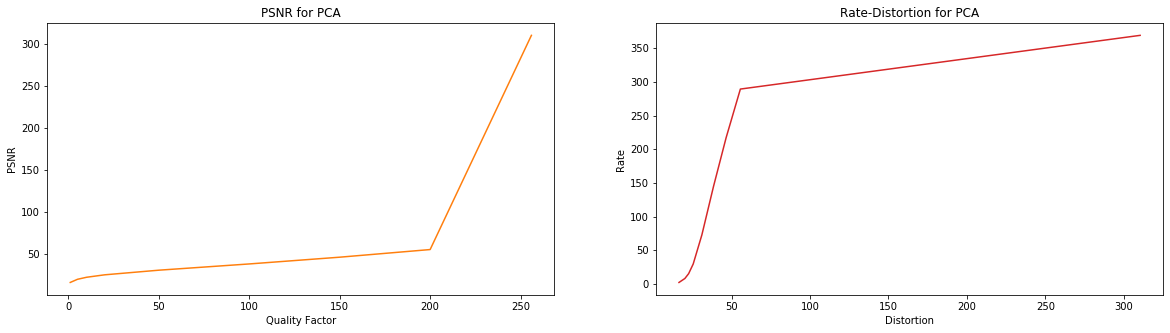

In [44]:
calc_metrics('Lenna.png', 'pca', [1, 5, 10, 20, 50, 100, 150, 200, 256])

## PSNR и Rate-Distortion для JPEG

/home/mk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  app.launch_new_instance()


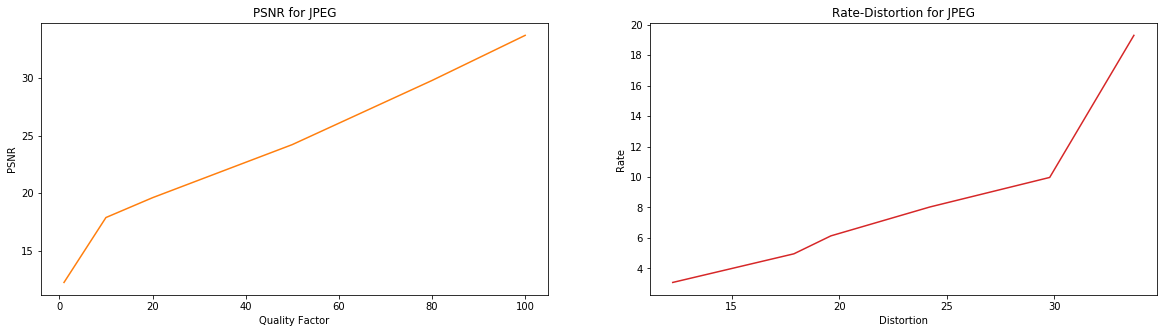

In [50]:
calc_metrics('Lenna.png', 'jpeg', [1, 10, 20, 50, 80, 100])